In [1]:
import torch
from torcheval.metrics.functional import multiclass_accuracy
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_spiral_dataset

In [2]:
# Set the global random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if you are using multi-GPU.
np.random.seed(SEED)
# random.seed(SEED)

# Ensures that operations will be deterministic on GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### PLot functions

In [3]:
def plot_scatter(X:np.ndarray, Y:np.ndarray):
    '''
    Show the scatter plot of flower dataset
    
    Parameters
    ----------
    X : numpy.ndarray [shape: (#features, #samples)]
        matrix of data; dtype: float64
    Y : numpy.ndarray [shape: (1, #samples)]
        array containing true labels 0 or 1; dtype: uint8 
    '''
    scatter=plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral)
    plt.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
    plt.xlabel('feature 1')
    plt.ylabel('feature 2')
    # plt.show()
    

def plot_decision_boundary(predict, X, Y):
    """
    Plot the decision boundary for logistic regression
    
    Parameters
    ----------
    predict : function
        predicted output; dtype=int8 
    parameters : dict
    X : numpy.ndarray [shape: (#features, #samples)]
        matrix of data; dtype: float64
    Y : numpy.ndarray [shape: (1, #samples)]
        array containing true labels 0 or 1; dtype: uint8
    """
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    # Y = None argument is dumpy as not used when print_accuracy=False
    Z = predict(torch.tensor(np.c_[xx.ravel(), yy.ravel()],dtype=torch.float32))
    Z=Z.argmax(1)
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plot_scatter(X,Y)

### Import data

torch.Size([1000, 2]) torch.Size([1000, 1])


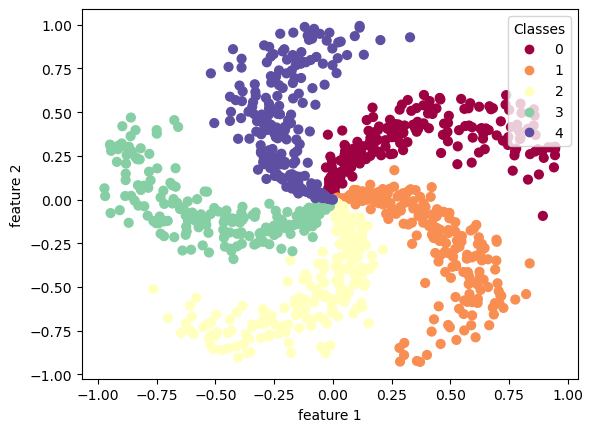

In [4]:
X_np,Y_np = load_spiral_dataset(N=1000, noise=0.2, K=5) # x->(D,N), y->(1,N)
X=torch.tensor(X_np.T, dtype=torch.float32) # x->(N,D)=(1000,2)
Y=torch.tensor(Y_np.reshape(-1,1), dtype=torch.float32) # y->(N,1)=(1000,1)
print(X.shape, Y.shape)
plot_scatter(X_np,Y_np)

In [5]:
unique_labels = torch.unique(Y)
print(unique_labels)

tensor([0., 1., 2., 3., 4.])


In [6]:
Y_true = torch.nn.functional.one_hot(Y[:,-1].to(torch.int64), num_classes=5)

In [7]:
Y_true[::100]

tensor([[1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1]])

### L Layer Neural Network Model

In [8]:
def L_layer_model(train_X, train_Y, layers_dims, learning_rate=0.0075, num_epochs=2000, activation_L_1="relu", activation_L="softmax", print_cost=False):
    """
    L layer neural network with different activation function on output layer option.
    
    Parameters
    ----------
    train_X : Tensor [shape: (#samples, #features)]; dtype=tf.float32
    train_Y : Tensor [shape: (#samples, 1)]; dtype=tf.float32
    layers_dims : list of int; list of number of nodes in each layer

    Returns
    -------
    forward : trained model
    costs : list of cost every 100 iteration
    """
    costs = []                                        # To keep track of the cost
    L = len(layers_dims) # number of layers in the network

    ## Initialize layers
    activations = torch.nn.ModuleDict({ 'sigmoid':torch.nn.Sigmoid(), 'tanh':torch.nn.Tanh(),
                'relu':torch.nn.ReLU(), 'lrelu':torch.nn.LeakyReLU(), 'softmax': torch.nn.Softmax(dim=1) })
    layers_list = []
    for in_f, out_f in zip(layers_dims, layers_dims[1:-1]):
        layers_list.append(torch.nn.Linear(in_f, out_f))
        layers_list.append(activations[activation_L_1])
    layers_list.append(torch.nn.Linear(layers_dims[-2], layers_dims[-1]))
    layers_list.append(activations[activation_L])
        
    forward = torch.nn.Sequential(*layers_list)
    
    # Set a base seed
    base_seed = 2024
    # Create a generator with the base seed
    gen = torch.Generator().manual_seed(base_seed)
    ## Initialize parameters
    for l in range(1, L-1):
        torch.nn.init.kaiming_uniform_(forward[2*(l-1)].weight, nonlinearity='relu', generator=gen)
        torch.nn.init.zeros_(forward[2*(l-1)].bias)
    torch.nn.init.xavier_uniform_(forward[2*((L-1)-1)].weight, generator=gen)
    torch.nn.init.zeros_(forward[2*((L-1)-1)].bias)
            
    optimizer = torch.optim.Adam(forward.parameters(), lr = learning_rate)
    ce = torch.nn.NLLLoss(reduction="sum")

    ## epochs loop
    for i in range(num_epochs): 
        ## forward pass
        train_Y_pred = forward(train_X)       # (m,n_L)
        cost = ce(torch.log(train_Y_pred), train_Y.argmax(1)) 
        # cost = torch.nn.functional.binary_cross_entropy(train_Y_pred, train_Y, reduction="mean")

        ## backward pass
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        ## Record the cost every 100 iterations
        if i % 100 == 0 or i == num_epochs-1:
            costs.append(cost.item())
            if print_cost:
                print(f"Cost in epochs {i+1}, {cost.item()}")
    
    return forward, costs


def plot_costs(costs, learning_rate):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

### Detailed info, plots demo

Cost in epochs 1, 1418.803466796875
Cost in epochs 101, 1179.2081298828125
Cost in epochs 201, 918.18798828125
Cost in epochs 301, 695.8707885742188
Cost in epochs 401, 498.5967712402344
Cost in epochs 501, 351.6801452636719
Cost in epochs 601, 251.5679168701172
Cost in epochs 701, 189.334716796875
Cost in epochs 801, 150.91307067871094
Cost in epochs 901, 124.67185974121094
Cost in epochs 1001, 105.37156677246094
Cost in epochs 1101, 90.84211730957031
Cost in epochs 1201, 78.91938781738281
Cost in epochs 1301, 69.27075958251953
Cost in epochs 1401, 61.33122253417969
Cost in epochs 1501, 55.07162857055664
Cost in epochs 1601, 49.179168701171875
Cost in epochs 1701, 43.928924560546875
Cost in epochs 1801, 39.854225158691406
Cost in epochs 1901, 36.64817428588867
Cost in epochs 2000, 34.047760009765625
train accuracy: 99.50000047683716 %


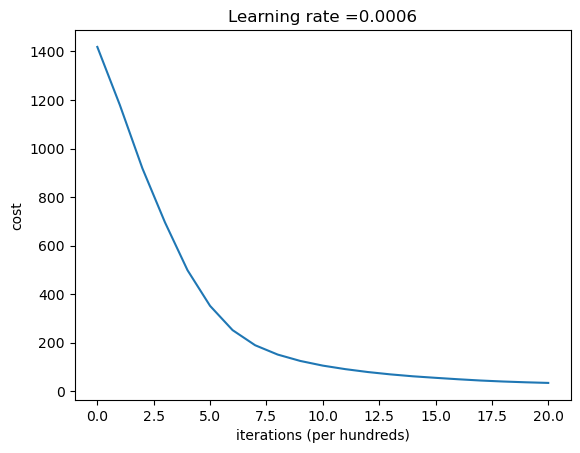

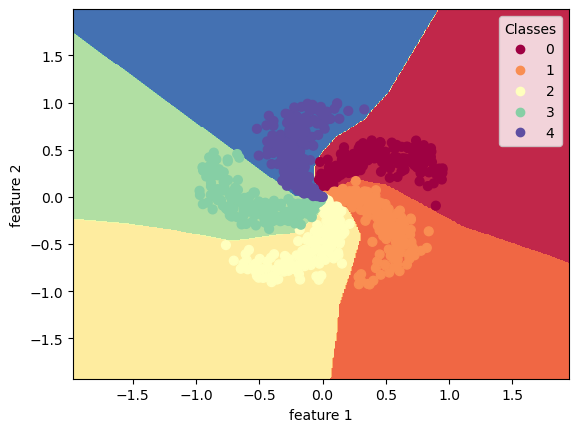

In [9]:
num_epochs=2000; activation_L_1="relu"; activation_L="softmax"
learning_rate = 0.0006; layers_dims=[X.shape[-1],12,12,12, 5]

forward, costs = L_layer_model(X, Y_true, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=True)
Y_pred=forward(X)
acc = multiclass_accuracy(input=Y_pred, target=Y_true.argmax(1))
print(f"train accuracy: { acc.item() *100 } %")
plot_costs(costs, learning_rate)
plot_decision_boundary(forward, X_np, Y_np)

### Single Neuron Model Run

Cost in epochs 1, 1380.6497802734375
Cost in epochs 101, 1352.3421630859375
Cost in epochs 201, 1326.0433349609375
Cost in epochs 301, 1301.0733642578125
Cost in epochs 401, 1277.31494140625
Cost in epochs 501, 1254.680419921875
Cost in epochs 601, 1233.08984375
Cost in epochs 701, 1212.4688720703125
Cost in epochs 801, 1192.7493896484375
Cost in epochs 901, 1173.8682861328125
Cost in epochs 1001, 1155.7672119140625
Cost in epochs 1101, 1138.3931884765625
Cost in epochs 1201, 1121.69677734375
Cost in epochs 1301, 1105.6337890625
Cost in epochs 1401, 1090.162841796875
Cost in epochs 1501, 1075.2464599609375
Cost in epochs 1601, 1060.8505859375
Cost in epochs 1701, 1046.9434814453125
Cost in epochs 1801, 1033.4962158203125
Cost in epochs 1901, 1020.4822387695312
Cost in epochs 2000, 1008.0010986328125
train accuracy: 76.49999856948853 %


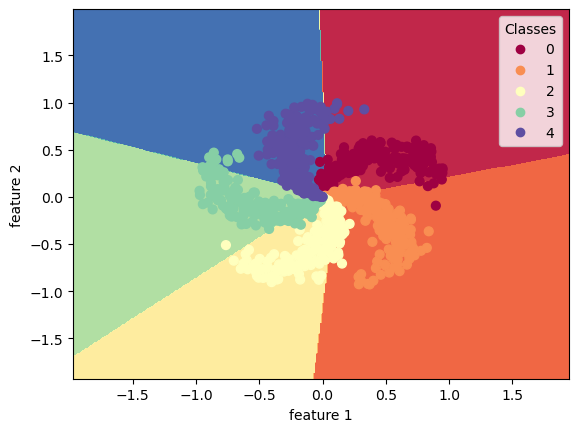

In [10]:
num_epochs=2000; activation_L_1="relu"; activation_L="softmax"
learning_rate = 0.0006; layers_dims=[X.shape[-1], 5]

forward, costs = L_layer_model(X, Y_true, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=True)
Y_pred=forward(X)
acc = multiclass_accuracy(input=Y_pred, target=Y_true.argmax(1))
print(f"train accuracy: { acc.item() *100 } %")
plot_decision_boundary(forward, X_np, Y_np)

### 2 Layers (or 1 hidden layer) Neural Network with 1 neuron in output layer

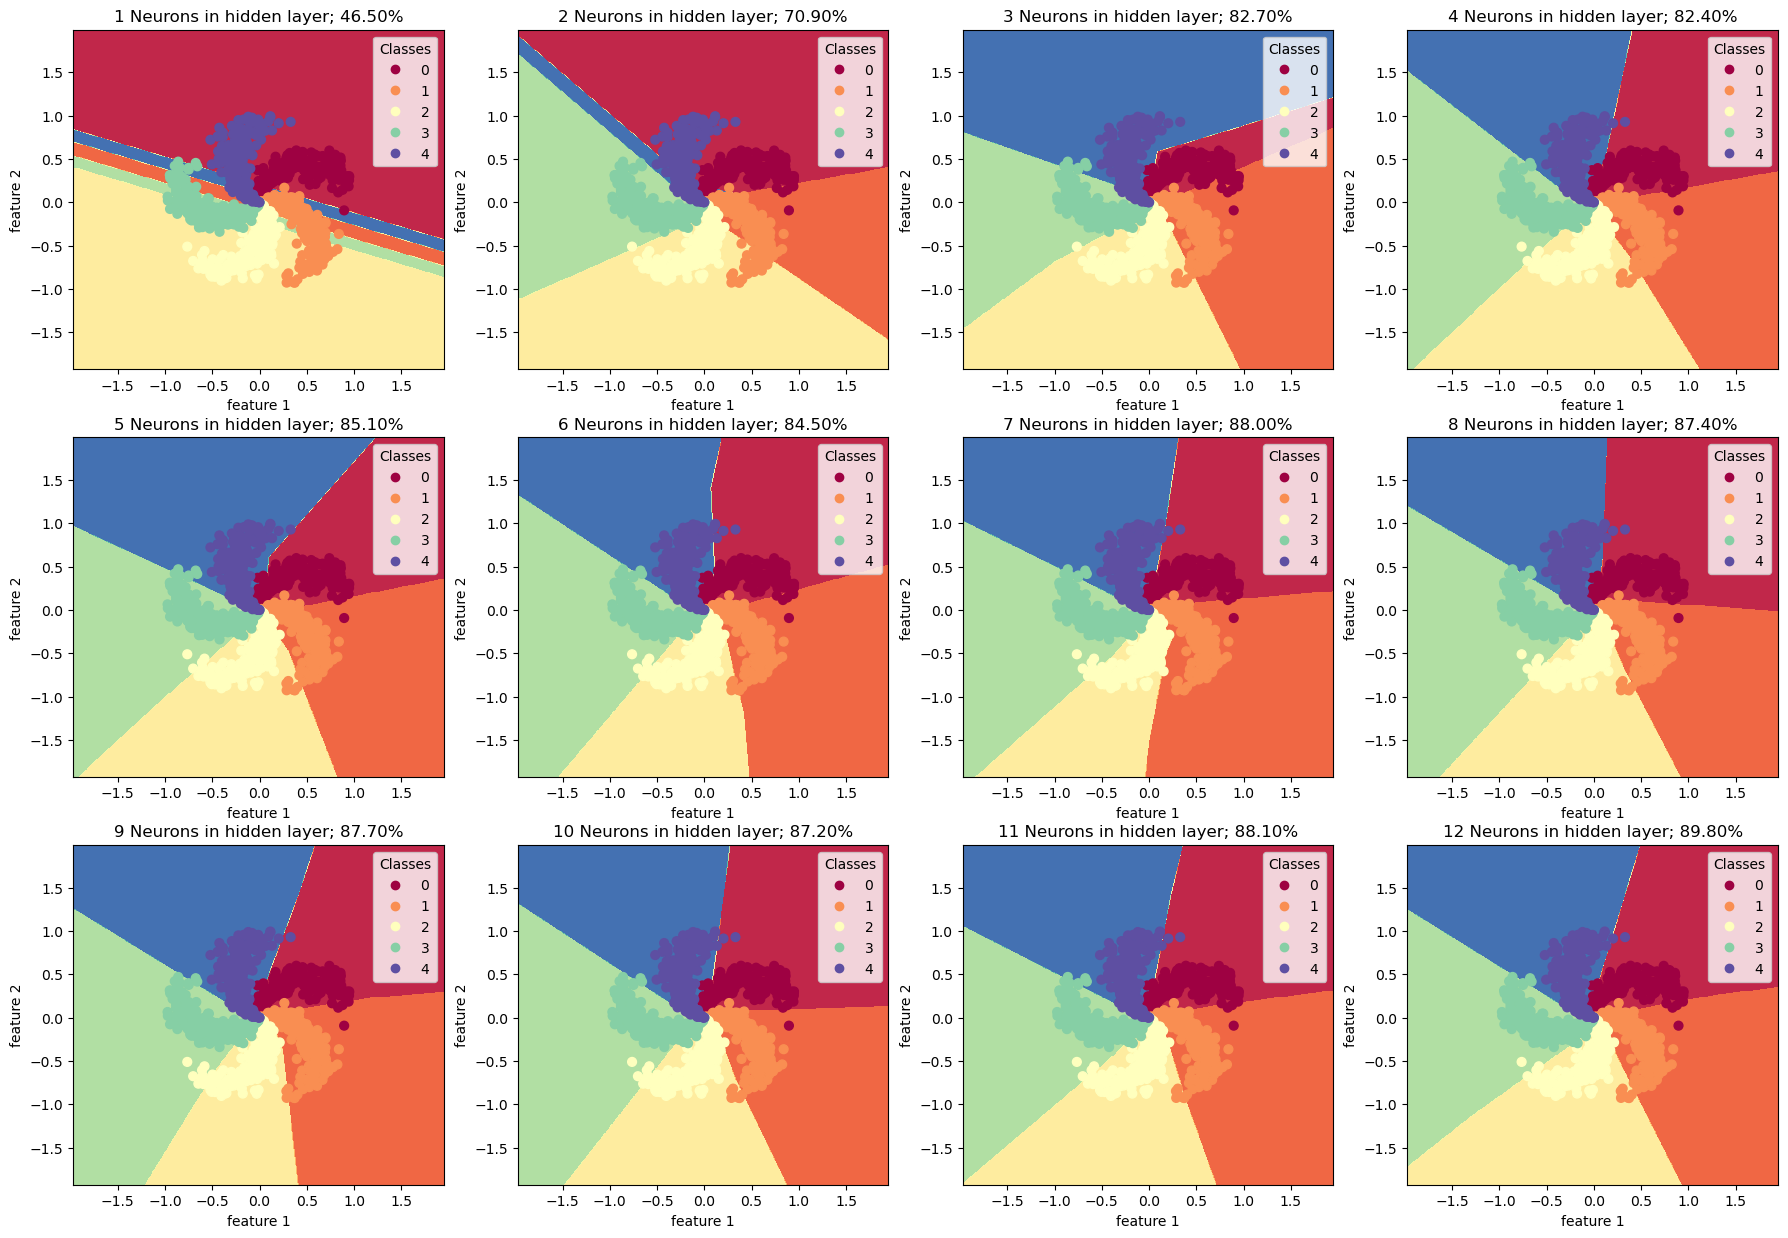

In [11]:
num_epochs=2000; activation_L_1="relu"; activation_L="softmax"
learning_rate = 0.0006; layers_dims=[X.shape[-1],1, 5]
plt.rcParams['figure.figsize'] = (22.0, 15.0) # width, height
for i in range(1,13):
    layers_dims=[X.shape[-1],i, 5]
    plt.subplot(3, 4, i)
    forward, costs = L_layer_model(X, Y_true, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=False)
    Y_pred=forward(X)
    acc = multiclass_accuracy(input=Y_pred, target=Y_true.argmax(1))
    plot_decision_boundary(forward, X_np, Y_np)
    plt.title(f"{i} Neurons in hidden layer; {acc.item()*100:.2f}%")


### 3 Layers (or 2 hidden layer) Neural Network with 1 neuron in output layer

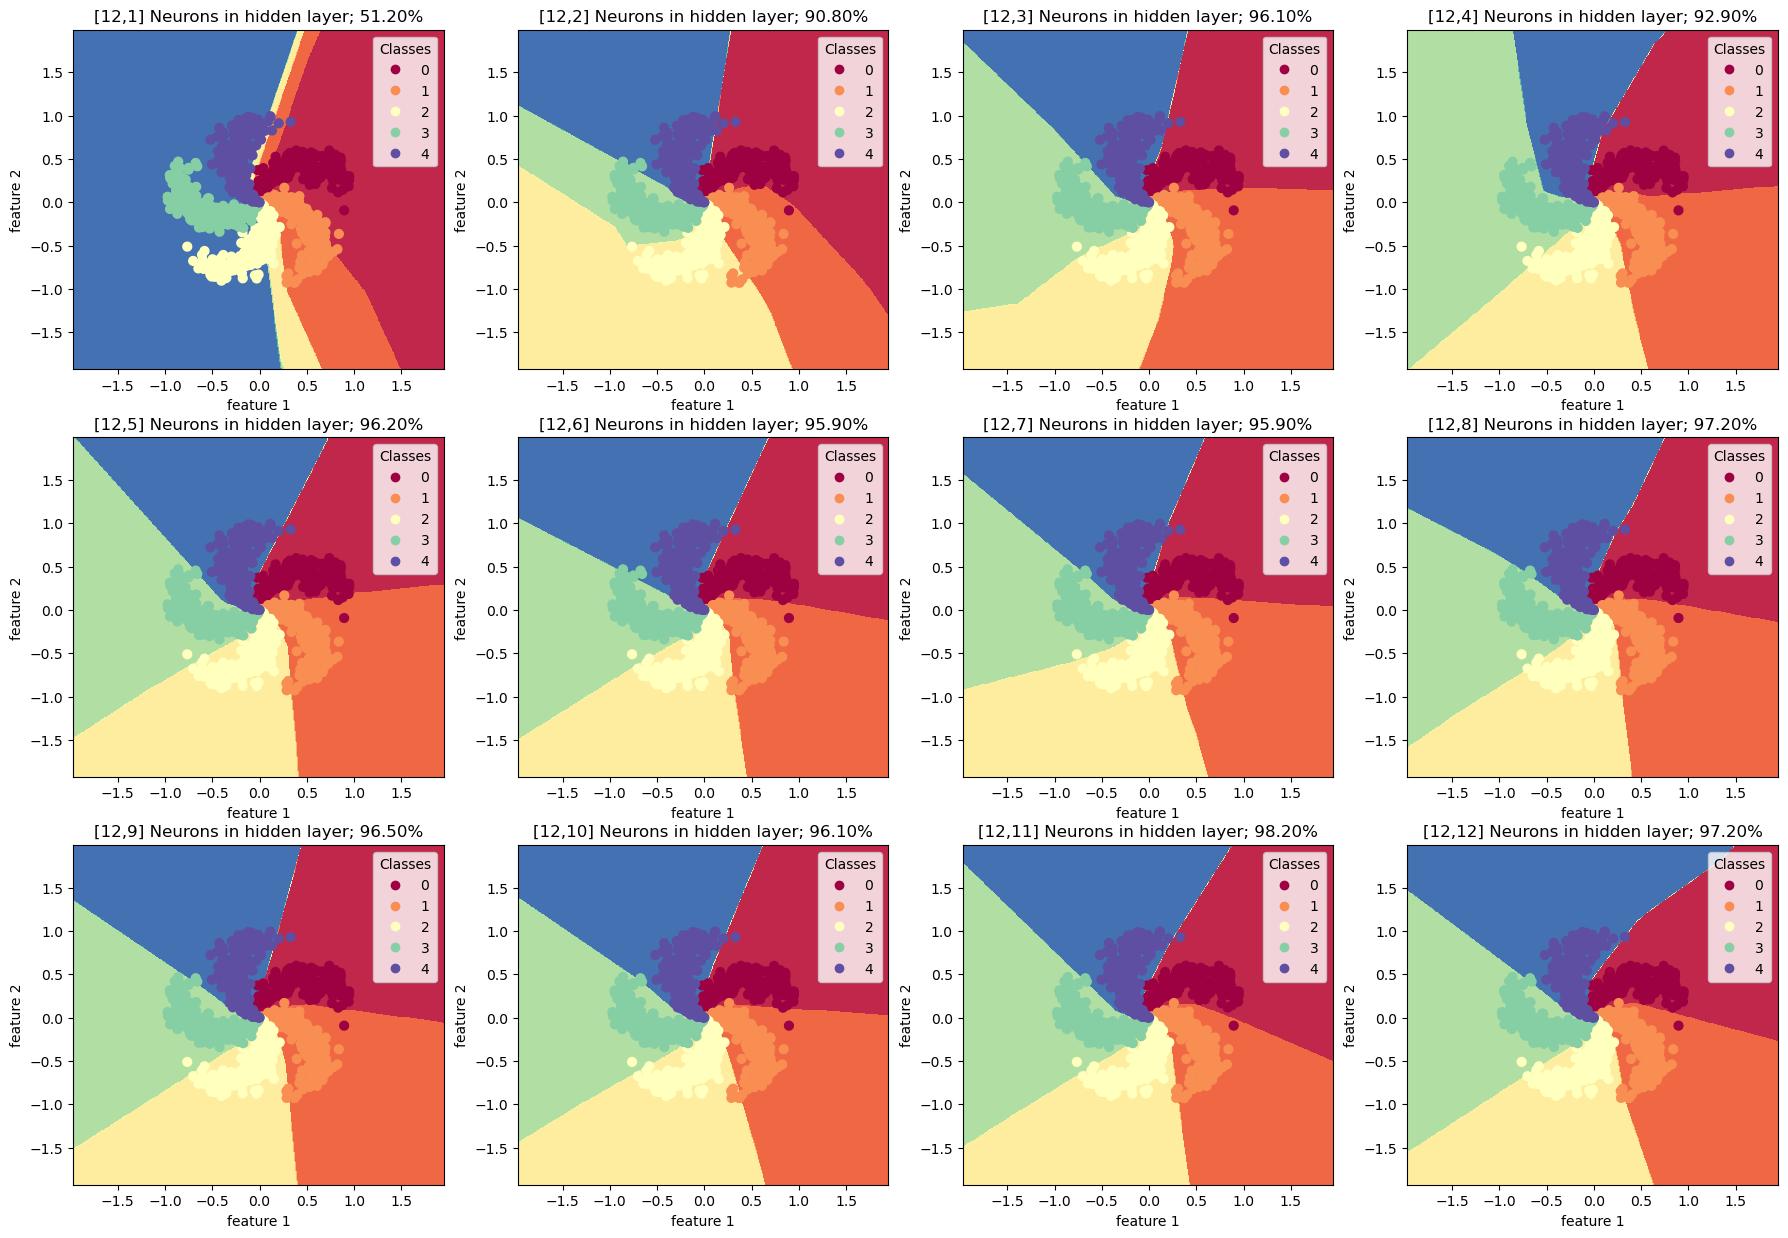

In [12]:
num_epochs=2000; activation_L_1="relu"; activation_L="softmax"
learning_rate = 0.0006; layers_dims=[X.shape[-1],12,1, 5]
plt.rcParams['figure.figsize'] = (22.0, 15.0) # width, height
for i in range(1,13):
    layers_dims=[X.shape[-1],12, i, 5]
    plt.subplot(3, 4, i)
    forward, costs = L_layer_model(X, Y_true, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=False)
    Y_pred=forward(X)
    acc = multiclass_accuracy(input=Y_pred, target=Y_true.argmax(1))
    plot_decision_boundary(forward, X_np, Y_np)
    plt.title(f"[12,{i}] Neurons in hidden layer; {acc.item()*100:.2f}%")


### 4 Layers (or 3 hidden layer) Neural Network with 1 neuron in output layer

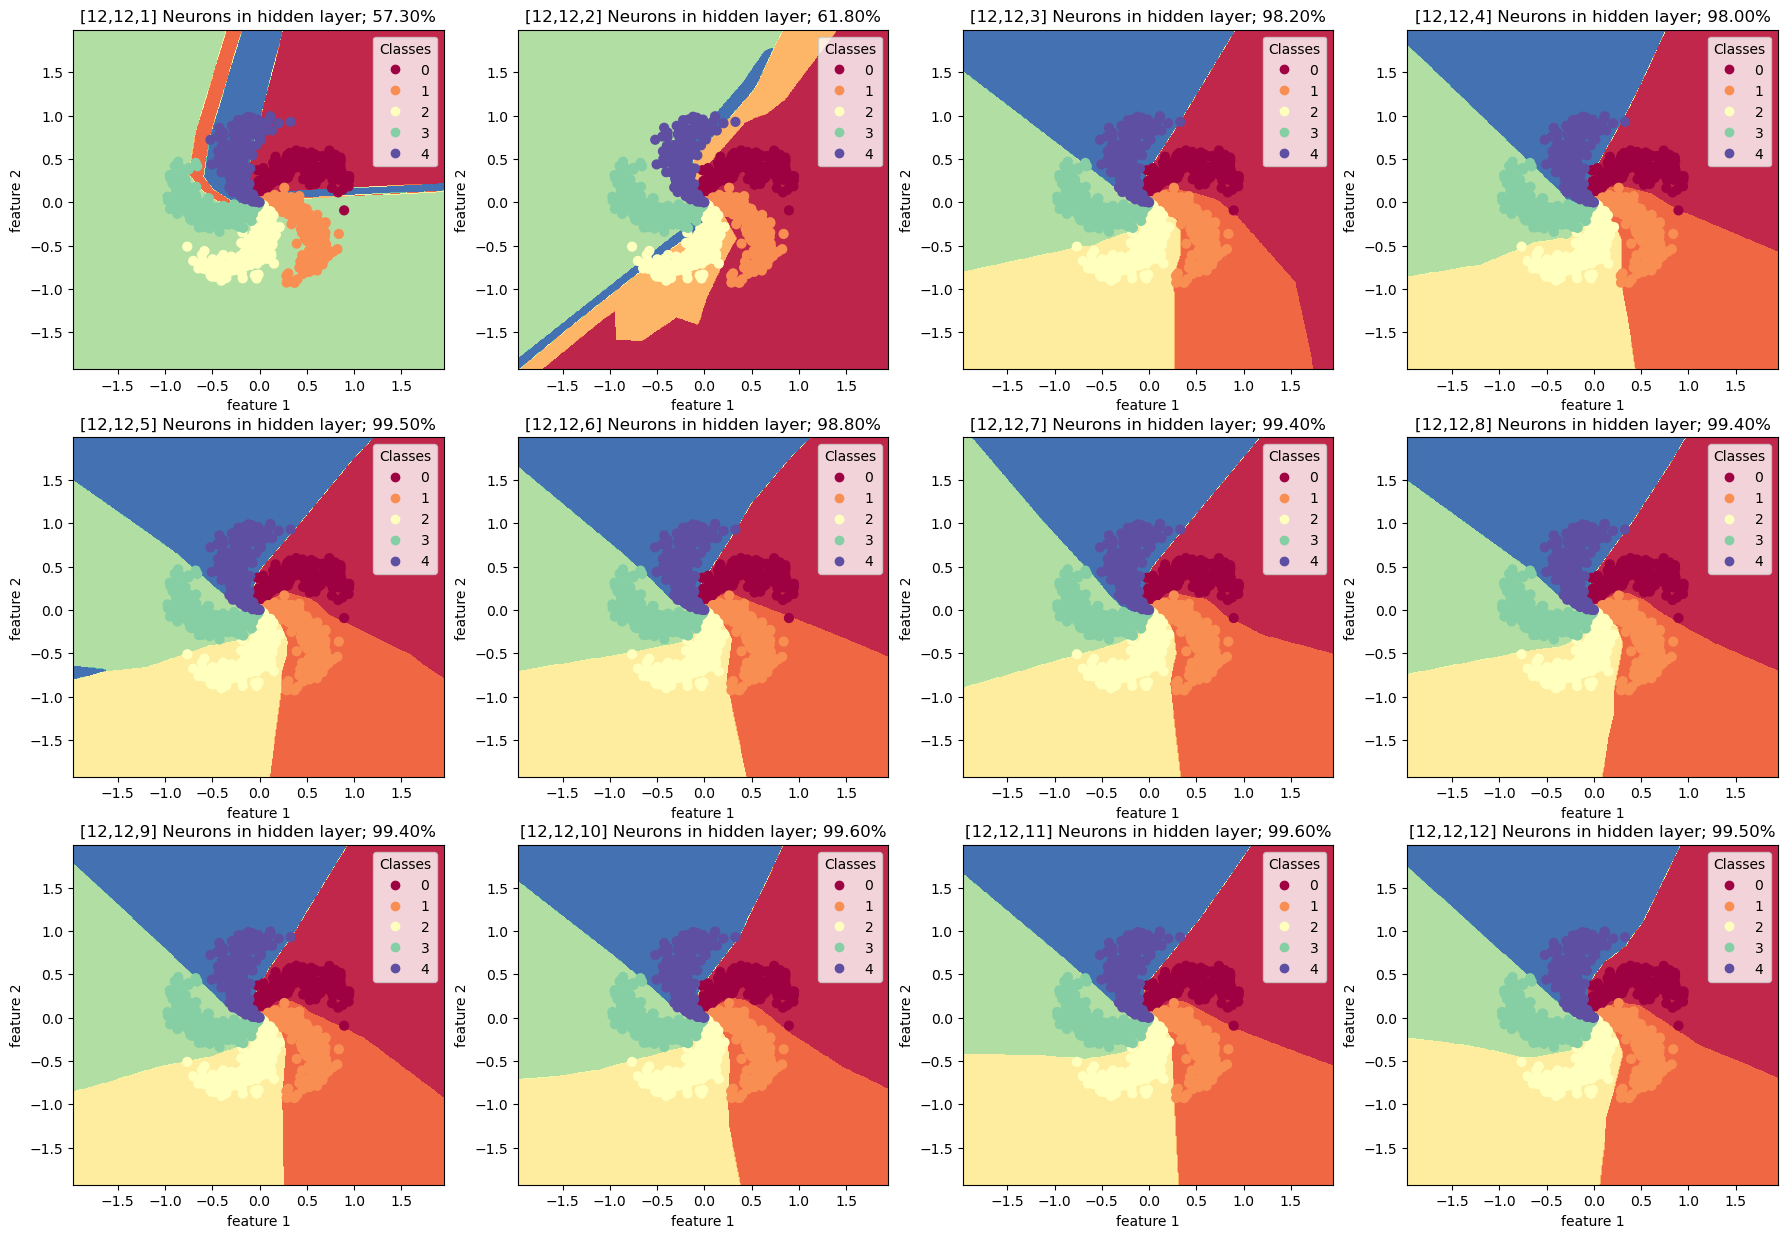

In [13]:
num_epochs=2000; activation_L_1="relu"; activation_L="softmax"
learning_rate = 0.0006; layers_dims=[X.shape[-1],12,12,1, 5]
plt.rcParams['figure.figsize'] = (22.0, 15.0) # width, height
for i in range(1,13):
    layers_dims=[X.shape[-1],12,12, i, 5]
    plt.subplot(3, 4, i)
    forward, costs = L_layer_model(X, Y_true, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=False)
    Y_pred=forward(X)
    acc = multiclass_accuracy(input=Y_pred, target=Y_true.argmax(1))
    plot_decision_boundary(forward, X_np, Y_np)
    plt.title(f"[12,12,{i}] Neurons in hidden layer; {acc.item()*100:.2f}%")


### Conclusion

4 layer neural networks in general give best results and adding more layers is increasing accuracy by much but probably overfitting.

Text(0.5, 1.0, '[12,12,12] Neurons in hidden layer; 99.50%')

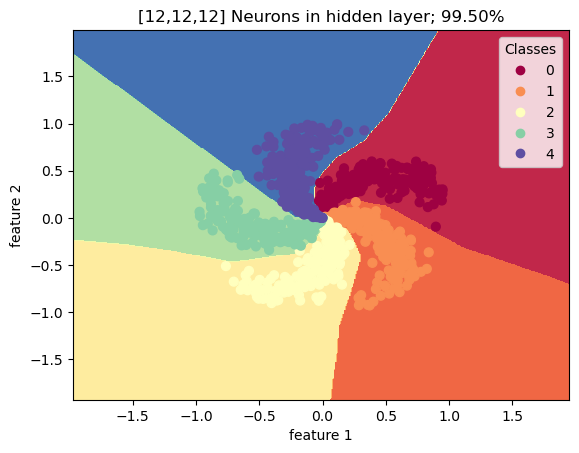

In [14]:
num_epochs=2000; activation_L_1="relu"; activation_L="softmax"
learning_rate = 0.0006; layers_dims=[X.shape[-1],12,12,12, 5]
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

layers_dims=[X.shape[-1],12, 12, 12, 5]
forward, costs = L_layer_model(X, Y_true, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=False)
Y_pred=forward(X)
acc = multiclass_accuracy(input=Y_pred, target=Y_true.argmax(1))
plot_decision_boundary(forward, X_np, Y_np)
plt.title(f"[12,12,12] Neurons in hidden layer; {acc.item()*100:.2f}%")